## <font color= grey > Profitability Maximization via Google, Apple and GE  Stock Options  </font>

### <font color= grey >Project Introduction </font>  
##### The goal of this analysis is to enable the maximization of investment return via stock options. Assuming an investment amount of 1 million USD, the user will be able to explore code that finds historical market and stock prices, forecasts those prices forward via a user-defined future time frame, and then selects the best mix of options (with some constraints) to maximize profit.

##### The analysis will be done in 3 sequential parts:
1. Predict future stock market movement in a user-defined future timeframe  [section C]
2. Mirror the market's movement using each stocks' beta and estimate the respective stock prices at the end of the given timeframe  [section C]
3. Value the stock options based on the forecasted stock prices and create the optimal portfolio to maximize profit  [section D]                                                                                                                            
                                                                                                                                 
                                                                                                           
###### * Please note that user assumptions are needed to be input manually for:                                                                                           
a. Current month and option expiration month [code block 2]                                                     
b. Date to start the market simulation [code block 10]

### <font color= grey > >>> Code Block Summary <<< </font> 

##### A. Package Upload and User Time-Frame Definitions
Code block 1. Package upload | Uploading packages for data handling, data visualization, web-scraping, and math programs  
Code block 2. User input to define MODEL SPECS forecasting timeframe and assignment of variable 'M' (number of months)  

##### B. Data Gathering, Scraping, and Formatting in Preparation for Forecast Simulation
Code block 3. Market and stock price import  
Code block 4. Market sigma (used later in forward-looking simulation)   
Code block 5. Treasury rate for risk-free proxy  
Code block 6. Finding each stock's beta  

##### C. Visualization, Market Prediction, and Stock Valuation   
Code block 7. Data visualization of each asset: both price and percentage return  
Code block 8. Predict market movement via simulation for the time-frame chosen in code block 2  
Code block 9. Visualize market movement prediction from previous code block    
Code block 10. Creating dataframe to house future S&P 500 predictions
Code block 11. Use forecasted market movement stock BETA to find forecasted stock price at end of forecast horizon

##### D. Scraping Option Prices, Option Valuation, and Investment Allocation       
Code block 12. Data gathering/scraping to get current option costs at various strike prices  
> 12(a) Google  
> 12(b) Facebook  
> 12(c) Netflix

Code block 13. Select the most profitable options of all 12 possible investment variations --> combine into DF           
Code block 14. Find the optimal investment allocation among the various option choices using Linear Programming (GEKKO package)      
Code block 15. Print final allocations and portfolio performance   

### <font color= grey > >>> A. Package Upload and User Time-Frame Definitions <<< </font>

In [15]:
### Code Block 1 | Package Upload ###
#####################################

# For data storage and manipulation
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime

# For visualization
import seaborn as sns # for visualization
%matplotlib inline
import matplotlib.pyplot as plt

# For importing of live and excel sheet investment data
from bs4 import BeautifulSoup
import requests

# For mathematical functionality
from mpmath import *
from scipy.optimize import linprog
import math
import numpy.random as npr
from pylab import mpl

In [16]:
### Code Block 2 | User to define forecast timeframe in creation of timeframe for actuals, forecasts, and option expiration ###
###############################################################################################################################

### USER INPUT NEEDED BELOW ###
###############################
# What is the current month and year / what month do we have actuals up until?
current_year = 2022
current_month = 9  # Input number of actual month (1 = Jan, 3 = March, etc)

### USER INPUT NEEDED BELOW ###
###############################
# What date is the option expiration? User can only select  January 2023 or January 2024
option_expiration_year = 2024 # User can only select 2023 or 2024
option_expiration_month = 1 # Can only select January...input number of actual month (1 = Jan)

## IMPORTANT STEP --> Assignment of month count to variable 'M' 
if option_expiration_year == current_year:
    M = option_expiration_month - current_month
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)

elif option_expiration_year - current_year == 1:
    M = (option_expiration_month - current_month + 12)
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)

elif option_expiration_year - current_year == 2:
    M = (option_expiration_month - current_month + 24)
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)
    
elif option_expiration_year - current_year == 3:
    M = (option_expiration_month - current_month + 36)
    print("Assuming current mth-yr is", current_month, "-", current_year, "and option expiration is", 
      option_expiration_month, "-", option_expiration_year, ", The forecast will be", M, 
      "months in the future. So 'M' = ", M)
    
else:
    print('Requested dates are outside of scope')

Assuming current mth-yr is 9 - 2022 and option expiration is 1 - 2024 , The forecast will be 16 months in the future. So 'M' =  16


### <font color= grey > >>> B. Data Gathering, Scraping, and Formatting in Preparation for Forecast Simulation <<< </font>

In [17]:
### Code Block 3 | Importing S&P500 and stock info from Alphavantage and combining into dataframe ###
#####################################################################################################

# Pulling historical stock info from AlphaVantage
import requests
import os
import json
from dotenv import load_dotenv

env_file = 'env_vars_ALPHAVANTAGE.env'
load_dotenv(env_file) # this has the AlphaVantage password
myAPIKey = os.getenv('ALPHAVANTAGE_KEY')
print("The Alpha Vantage key is", myAPIKey, "and has been successfully implemented")

## For S&P500 market data
API_URL = "https://www.alphavantage.co/query"
# for S&P500 data 
tickers = ['SPY']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": "myAPIKey" # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    SPY = (data['Monthly Adjusted Time Series'])  # Monthly Adjusted Time Series
    

## For stock 1: Facebook
API_URL = "https://www.alphavantage.co/query"
# for Apple data 
tickers = ['META']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": myAPIKey # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    FACEBOOK = (data['Monthly Adjusted Time Series'])  # Monthly Adjusted Time Series

    
## for Stock 2: Netflix
API_URL = "https://www.alphavantage.co/query"
# for GE data
tickers = ['NFLX']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": myAPIKey # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    NETFLIX = (data['Monthly Adjusted Time Series'])  # Monthly Adjusted Time Series

    
## for Stock #3: Google
API_URL = "https://www.alphavantage.co/query"
# the ticker we are looking up 
tickers = ['AAPL']
# for the chosen ticker, issue requests to the web service
for ticker in tickers:
    raw_data = {
        "function": "TIME_SERIES_MONTHLY_ADJUSTED", # requesting monthly average data
        "symbol": ticker, # looks at the ticker 
        "datatype": "json", # the format of the data we want
        "apikey": myAPIKey # uses the API key from the env_file
             }
    response = requests.get(API_URL, raw_data)
    data = response.json()
    print(ticker, "is successfully uploaded")
    APPLE = (data['Monthly Adjusted Time Series'])  # Monthly Adjusted Time Series
    

# changing each stock's JSON file into a dataframe     
df_SPY = pd.DataFrame(SPY) # turn JSON into a dataframe
df_SPY = df_SPY.transpose() # transpose it
df_SPY = df_SPY['5. adjusted close'] # take only the "adjusted close" column
df_SPY = df_SPY.reset_index(inplace = False) # keeping the month column for S&P500 (we only need it for one of the datasets)

df_FACEBOOK = pd.DataFrame(FACEBOOK) # turn JSON into a dataframe
df_FACEBOOK = df_FACEBOOK.transpose() # transpose it
df_FACEBOOK = df_FACEBOOK['5. adjusted close'] # take only the "adjusted close" column

df_NETFLIX = pd.DataFrame(NETFLIX) # turn JSON into a dataframe
df_NETFLIX = df_NETFLIX.transpose() # transpose it
df_NETFLIX = df_NETFLIX['5. adjusted close'] # take only the "adjusted close" column

df_APPLE = pd.DataFrame(APPLE) # turn JSON into a dataframe
df_APPLE = df_APPLE.transpose() # transpose it
df_APPLE = df_APPLE['5. adjusted close'] # take only the "adjusted close" column


## Checking length of Facebook (Meta), Netflix, and Apple Dataframes before combining into dataframe

# Checking that all dataframes are the same legnth 
print("Length of SPY data is", len(df_SPY),",",
      "Length of Apple data is", len(df_APPLE),",", 
      "Length of Netflix data is", len(df_NETFLIX),",", 
      "Length of Facebook data is", len(df_FACEBOOK),",")

if len(df_SPY) == len(df_APPLE) == len(df_NETFLIX) == len(df_FACEBOOK): # ARE ALL DATAFRAMES EQUAL TO EACHOTHER'S LENGTH?
    print("All dataframes are of equal length. You are clear to Merge!")
else:
    print('The dataframes are NOT of equal length...so the longer datasets will be cut down to match the shortest one')
    
    
##### Combining all dates, market, and stock prices into one dataframe #####
############################################################################

# Turning each Dataframe into a numpy array for ease-of-use 
np_APPLE = np.array((df_APPLE))
np_NETFLIX = np.array((df_NETFLIX))
np_FACEBOOK = np.array((df_FACEBOOK))

min_length = min(len(df_SPY), len(df_APPLE), len(df_FACEBOOK), len(df_NETFLIX))

# combining market and stock data into 1 array  
vstacked = np.vstack((df_SPY.iloc[0:min_length, 0], df_SPY.iloc[0:min_length, 1], np_APPLE[0:min_length], np_FACEBOOK[0:min_length], np_NETFLIX[0:min_length]))

# flipping 
vstacked_data = pd.DataFrame(vstacked).transpose()

# naming columns 
vstacked_data.columns = ['Date', 'SPY', 'Apple', 'Facebook', 'Netflix']

# changing data types
vstacked_data['Date'] = pd.to_datetime(vstacked_data['Date'])
vstacked_data['SPY'] = vstacked_data['SPY'].astype(float)
vstacked_data['Apple'] = vstacked_data['Apple'].astype(float)
vstacked_data['Facebook'] = vstacked_data['Facebook'].astype(float)
vstacked_data['Netflix'] = vstacked_data['Netflix'].astype(float)

# making date the index
vstacked_data = vstacked_data.set_index('Date')
print(vstacked_data)

The Alpha Vantage key is SCFN03L8NMSR0FVC and has been successfully implemented
SPY is successfully uploaded
META is successfully uploaded
NFLX is successfully uploaded
AAPL is successfully uploaded
Length of SPY data is 274 , Length of Apple data is 274 , Length of Netflix data is 244 , Length of Facebook data is 124 ,
The dataframes are NOT of equal length...so the longer datasets will be cut down to match the shortest one
                 SPY     Apple  Facebook   Netflix
Date                                              
2022-09-16  385.5600  150.7000   146.290  240.1300
2022-08-31  393.5505  157.2200   162.930  223.5600
2022-07-29  410.2912  162.2843   159.100  224.9000
2022-06-30  375.6944  136.5301   161.250  174.8700
2022-05-31  409.4625  148.6333   193.640  197.4400
...              ...       ...       ...       ...
2012-10-31  117.0139   18.2290    21.110   11.3199
2012-09-28  119.1828   20.4271    21.660    7.7771
2012-08-31  116.2355   20.3700    18.058    8.5314
2012-07-31

In [18]:
### Code Block 4 | Finding sigma for the market (using SPY as barometer) for prediction model input later ###
############################################################################

## Finding sigma for monthly market returns to plug into the forecasting simulation
market_predict = vstacked_data['SPY']
## The delta of monthly returns should not be confused with the standard deviation of market levels. 
## This is the standard deviation of the actual percentage change. 
monthly_deltas = market_predict.pct_change(-1) # the "-1" reverses the order so that the pct_change reflects delta from previous month to current month
print("The sigma of monthly returns for past", round(len(vstacked_data)/12,1), "years is", round(np.std(monthly_deltas)*100,2),"%") # Sigma of monthly returns (not to be confused with standard deviation of monthly market levels)

The sigma of monthly returns for past 10.3 years is 3.99 %


In [19]:
### Code Block 5 | Importing of Risk Free Rate (implied from the treasury yield curve) ###
######################################################################################################

## Finding current risk free rate via a data scrape (risk-free-rate is proxied via 2-year treasury yield captured MTD) 
## This rate is used as a proxy for the risk-free rate.  


# Pulling historical stock info from AlphaVantage
import requests
import os
import json
from dotenv import load_dotenv

env_file = 'env_vars_ALPHAVANTAGE.env'
load_dotenv(env_file) # this has the AlphaVantage password
myAPIKey = os.getenv('ALPHAVANTAGE_KEY')
print("The Alpha Vantage key is", myAPIKey, "and has been successfully implemented")

## For Treasury Risk Free Rate market data
API_URL = "https://www.alphavantage.co/query"
raw_data = {
"function": 'TREASURY_YIELD', # requesting monthly average data
"maturity": '2year',
"datatype": "json", # the format of the data we want
"apikey": "myAPIKey" # uses the API key from the env_file
             }
response = requests.get(API_URL, raw_data)
data = response.json()
print("data is successfully uploaded")
RFR = float((data['data'][0]['value']))  # Monthly Adjusted Time Series
print(RFR,"% is the ", data['name'], "(i.e. the Risk Free Rate)")

The Alpha Vantage key is SCFN03L8NMSR0FVC and has been successfully implemented
data is successfully uploaded
3.25 % is the  2-Year Treasury Constant Maturity Rate (i.e. the Risk Free Rate)


In [20]:
### Code Block 6 | Getting Beta's for all three stocks from Yahoo Finance for prediction model input later ###
##############################################################################################################

# Importing needed packages     
from bs4 import BeautifulSoup
import requests    

## Getting Facebook beta measure ##
URL = 'https://finance.yahoo.com/quote/META?p=META&.tsrc=fin-srch'
content = requests.get(URL)
soup = BeautifulSoup(content.text, 'html.parser')
rows = soup.find_all('tr')

measures = []
scores = []
for row in rows:
    cells = row.findAll('td') # Go inside each row and find the cells marked with 'td' 
    if(len(cells) > 0):
       measure = cells[0].text.strip() # As the loop scrolls through, grab the names in first slot of each row
       measures.append(measure)
       score = cells[1].text.strip() # As the loop scrolls through, grab the values in second slot of each row
       scores.append(score)
#        print(measure, score, sep = " | ")
Facebook_beta = scores[9] # the 10th spot (index 9) is where the 5-year beta is kept


## Getting Netflix beta measure ##
URL = 'https://finance.yahoo.com/quote/NFLX/'
content = requests.get(URL)
soup = BeautifulSoup(content.text, 'html.parser')
rows = soup.find_all('tr')

measures = []
scores = []
for row in rows:
    cells = row.findAll('td') # Go inside each row and find the cells marked with 'td' 
    if(len(cells) > 0):
       measure = cells[0].text.strip() # As the loop scrolls through, grab the names in first slot of each row
       measures.append(measure)
       score = cells[1].text.strip() # As the loop scrolls through, grab the values in second slot of each row
       scores.append(score)
#        print(measure, score, sep = " | ")
Netflix_beta = scores[9] # the 10th spot (index 9) is where the 5-year beta is kept


## Getting APPLE beta measure ##
URL = 'https://finance.yahoo.com/quote/AAPL?p=AAPL&.tsrc=fin-srch'
content = requests.get(URL)
soup = BeautifulSoup(content.text, 'html.parser')
rows = soup.find_all('tr')

measures = []
scores = []
for row in rows:
    cells = row.findAll('td') # Go inside each row and find the cells marked with 'td' 
    if(len(cells) > 0):
       measure = cells[0].text.strip() # As the loop scrolls through, grab the names in first slot of each row
       measures.append(measure)
       score = cells[1].text.strip() # As the loop scrolls through, grab the values in second slot of each row
       scores.append(score)
#        print(measure, score, sep = " | ")
Apple_beta = scores[9] # the 10th spot (index 9) is where the 5-year beta is kept


## Creating a combined dataframe with stock Betas
beta_combine = pd.DataFrame({"Company" : ['Facebook', 'Netflix', 'Apple'], "5YrBeta" :[float(Facebook_beta), float(Netflix_beta), float(Apple_beta)]})
beta_combine.set_index('Company') # Making company the index column


##############################################################
## FINAL BETA's of EACH STOCK ##
Facebook_beta = beta_combine.iloc[0,1]
Netflix_beta = beta_combine.iloc[1,1]
Apple_beta = beta_combine.iloc[2,1]

print('Facebook beta is', Facebook_beta,'|', 'Netflix beta is', Netflix_beta,'|', 'Apple beta is', Apple_beta)

Facebook beta is 1.3 | Netflix beta is 1.34 | Apple beta is 1.23


### <font color= grey > >>> C. Visualization, Market Prediction, and Stock Valuation <<< </font>

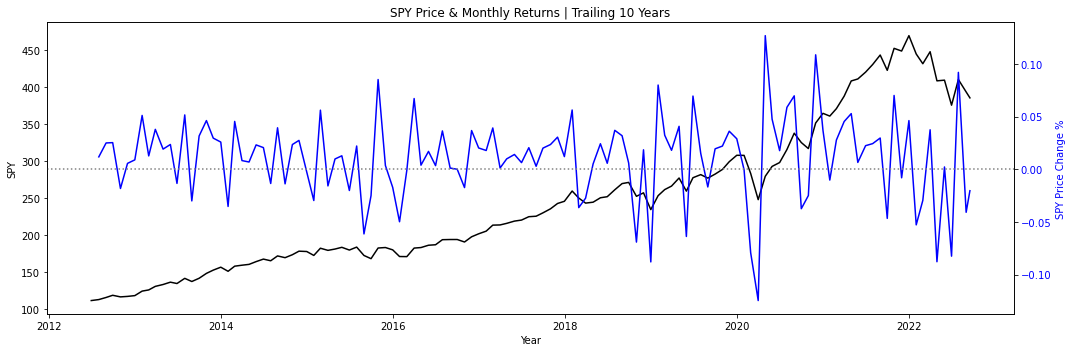

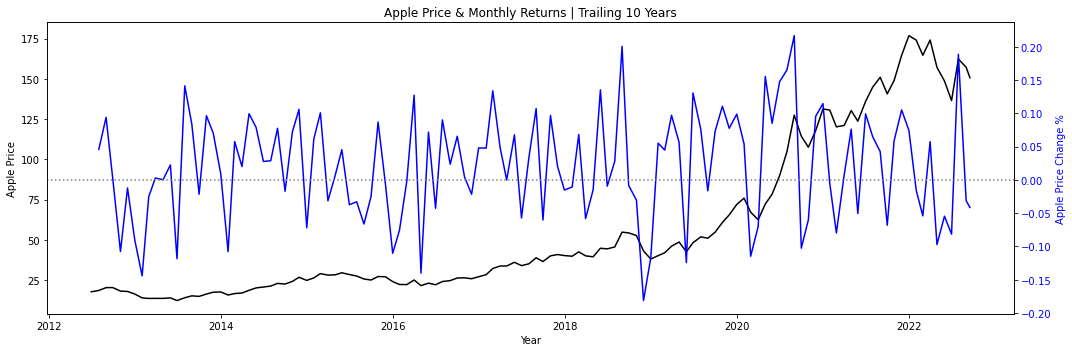

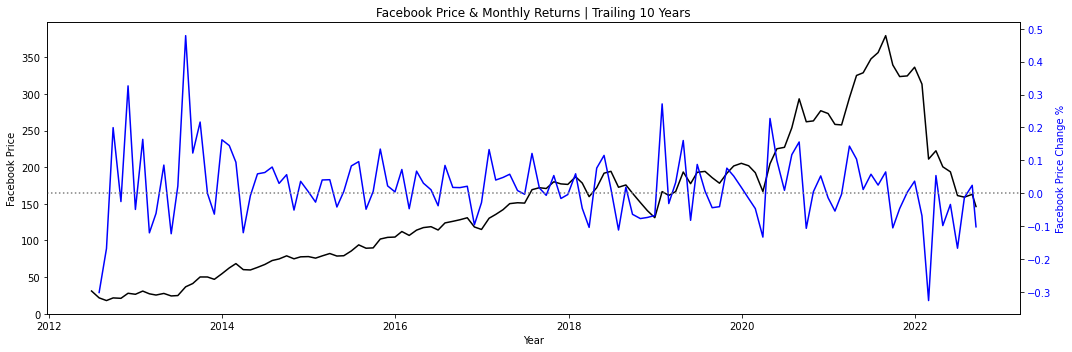

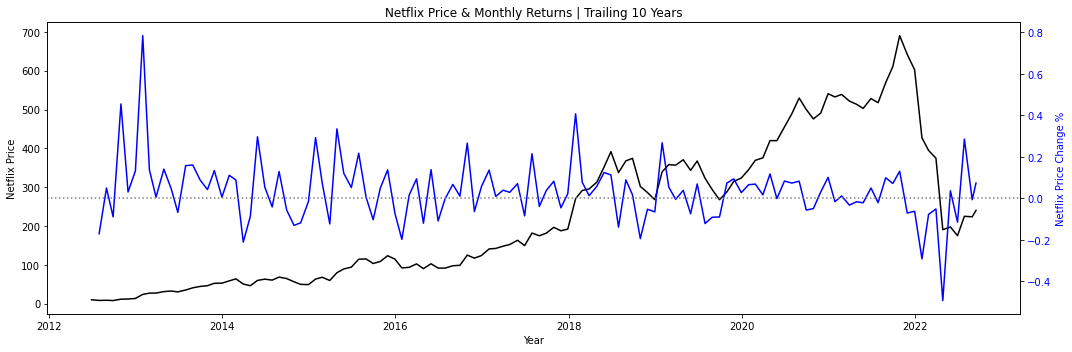

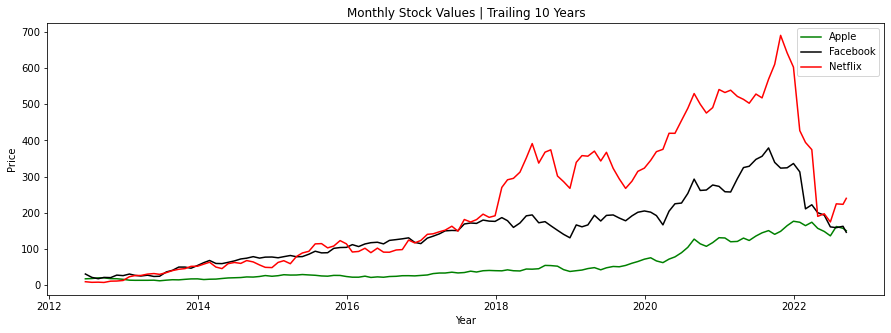

In [21]:
### Code Block 7 | Showing visuals of all assets included in this analysis ###
##############################################################################

# Creating a dataframe to showcase monthly returns for each asset 
SPY_trend = vstacked_data['SPY'].pct_change(-1)
Facebook_trend = vstacked_data['Facebook'].pct_change(-1)
Netflix_trend = vstacked_data['Netflix'].pct_change(-1)
Apple_trend = vstacked_data['Apple'].pct_change(-1)

# Resize all the graphs to be longer
plt.rcParams["figure.figsize"] = (15,5)

# S&P500 MARKET VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('SPY Price & Monthly Returns | Trailing 10 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('SPY', color = 'black')
ax1.plot(vstacked_data['SPY'], color = 'black')
ax1.tick_params(axis='y', labelcolor = 'black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('SPY Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(SPY_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# APPLE VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('Apple Price & Monthly Returns | Trailing 10 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Apple Price', color='black')
ax1.plot(vstacked_data['Apple'], color='black')
ax1.tick_params(axis='y', labelcolor='black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('Apple Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(Apple_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# FACEBOOK VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('Facebook Price & Monthly Returns | Trailing 10 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Facebook Price', color='black')
ax1.plot(vstacked_data['Facebook'], color='black')
ax1.tick_params(axis='y', labelcolor='black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('Facebook Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(Facebook_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# NETFLIX VISUALS
fig, ax1 = plt.subplots()
# SETTING UP 1ST GRAPH ON MAIN Y-LABEL
plt.title('Netflix Price & Monthly Returns | Trailing 10 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Netflix Price', color='black')
ax1.plot(vstacked_data['Netflix'], color='black')
ax1.tick_params(axis='y', labelcolor='black')
# SETTING UP 2ND Y-AXIS
ax2 = ax1.twinx()
ax2.set_ylabel('Netflix Price Change %', color='blue')  # THIS IS THE Y AXIS 
ax2.plot(Netflix_trend, color='blue')
plt.axhline(y=0.0, color='grey', linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout() # TO ADJUST FOR RIGHTSIDE DIMENSIONS
plt.show()


# All Stock prices combined onto one graph
fig, ax1 = plt.subplots()
plt.title('Monthly Stock Values | Trailing 10 Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price', color = 'black')
ax1.plot(vstacked_data['Apple'], color = 'green')
ax1.plot(vstacked_data['Facebook'], color = 'black')
ax1.plot(vstacked_data['Netflix'], color = 'red')
ax1.tick_params(axis='y', labelcolor = 'black')
plt.legend(['Apple', 'Facebook', 'Netflix'])

In [22]:
### Code Block 8 | Monthly Market Simulations  ###
##################################################

## These monthly market simulations will be used to come to a final market level and value each stock using the stock's 
## respective beta to the market over the future time interval that the user has chosen above. 

## Setting up parameters before simulation
# the variable 'M' is uqivalent with how many discrete time intervals (i.e. months) we need to forecast into the future
# 'M' has already been created in code box 2 above
I = 10000 # number of simulation (paths) for each month
T = M/12 # horizon in years
dt = T / M # Proportion of time for each interval between steps
S = np.zeros((M+1, I)) # define matrix of zeros --> it's 'M+1' because the first row is the starting price of the market  
r = RFR/100 # risk-free interest rate found above 
sigma = np.std(monthly_deltas) # represets constant volatility of monthly returns
S[0] = vstacked_data['SPY'][0] # setting up starting price

# For each time slice, generate a new price, based on the prior price and r, sigma, dt, and unit normal random numbers
for t in range(1, M+1): 
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * npr.standard_normal(I))

# 'S' represents a vector of normally distributed simulated market returns

Text(0.5, 1.0, 'Forecasted SPY Pathway Simulations: 100')

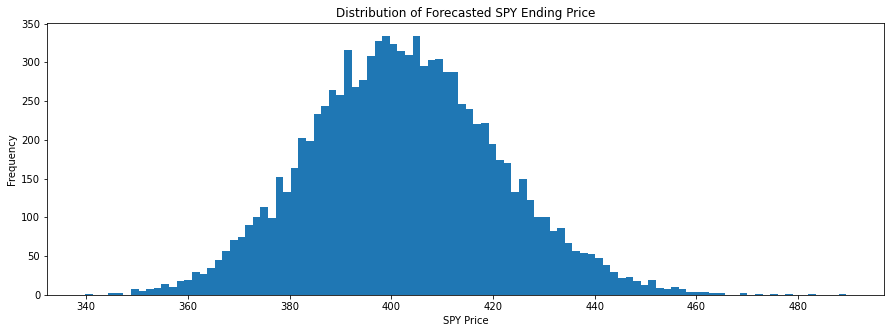

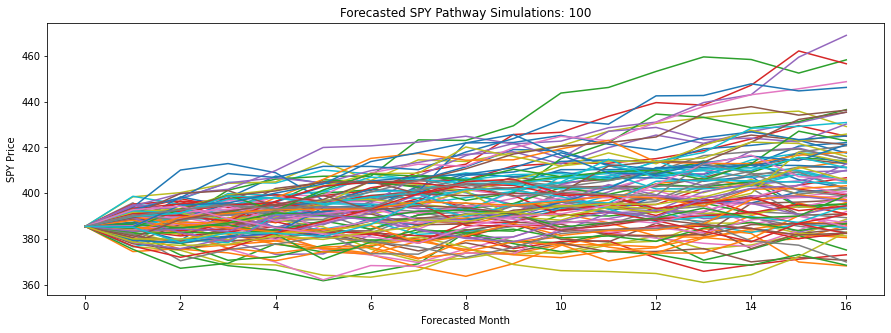

In [23]:
### Code Block 9 | Market Simulation Visualizations ###
#######################################################

# PLot Histogram of Returns
plt.figure(figsize=(15,5))
plt.title('Distribution of Forecasted SPY Ending Price')
plt.hist(S[-1], bins=100)
plt.xlabel('SPY Price')
plt.ylabel('Frequency')

# PLot Decision Paths
npathsToPlot = 100
plt.figure(figsize=(15,5))
plt.plot(S[:,:npathsToPlot], lw=1.5)
plt.xlabel('Forecasted Month')
plt.ylabel('SPY Price')
plt.title("Forecasted SPY Pathway Simulations: 100")

In [24]:
### Code Block 10 | Creating dataframe to be filled with future SPY predictions #######
#######################################################################################

### Creating a future-facing dataframe to be filled in with the future forecasted market

### USER INPUT NEEDED BELOW ###
###############################
forecast_start_year = 0 # put the index value (i.e. 0 = "2022", 1 = "2023", 2 = "2024")
forecast_start_month = 9 # put the index value (i.e. 0 = "January", 3 = "April", 11 = "December")

# Index list of years and months for the user to choose from 
year_name = [2022, 2023, 2024]
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Creating blank list to house each month and year name
year_list = []
month_list = []

# This counter will count one loop for every month we predict forward
counter = 0
while counter < M: # 'M' is the amount of months input in the forecast (see code block 2 above)
    # creating monthly list
    month = month_name[forecast_start_month]
    month_list.append(month)
    
    # creating annual year list
    year = year_name[forecast_start_year]
    year_list.append(year)
    
    # This counter keeps the total loops to 'M'
    counter = counter + 1
    
    if forecast_start_month+1 > 11: # If the month index is greater than December, roll it forward to January
        forecast_start_month = forecast_start_month+1-12
        forecast_start_year = forecast_start_year+1
    
    else: # Add 1 to get to the next month
        forecast_start_month = forecast_start_month+1
        forecast_start_year = forecast_start_year

# We now have a final dataframe of months and years to input
df_forecasted = pd.DataFrame([year_list, month_list])
df_forecasted = df_forecasted.transpose()
df_forecasted.rename(columns = {0:'Year', 1:'Month'}, inplace = True)


## Assigning one average value for each month's random simulations to come to a monthly market prediction 

MonthSim = []
for i in range(0, M+1):
    MonthSim.append(S[i].mean()) # Finding mean of each month's market simulation means
MonthSim = pd.DataFrame(MonthSim)
dfMonth_delta = MonthSim.pct_change() # Combined with Beta in code block 11 (below) to forecast future stock values

# Combining timeframe dataframe and monthly predictions from the simulations
future_forecast = np.hstack([df_forecasted, MonthSim.iloc[1:M+1]])
future_forecast = pd.DataFrame(future_forecast)
future_forecast.rename(columns = {0:'Year', 1:'Month', 2:'Forecast'}, inplace = True)
print("The", len(future_forecast), "month macro stock market prediction is") 
print(future_forecast)

The 16 month macro stock market prediction is
    Year Month    Forecast
0   2022   Oct  386.702249
1   2022   Nov  387.771243
2   2022   Dec  388.815026
3   2023   Jan  389.885863
4   2023   Feb  390.921852
5   2023   Mar  392.039694
6   2023   Apr  393.002943
7   2023   May    394.0917
8   2023   Jun  395.150238
9   2023   Jul  396.311833
10  2023   Aug  397.314297
11  2023   Sep   398.26663
12  2023   Oct  399.336731
13  2023   Nov  400.387906
14  2023   Dec  401.468347
15  2024   Jan  402.441984


In [25]:
### Code Block 11 | Use forecasted market movement (via SPY) x stock beta to find forecasted stock price at end of forecast horizon ###
###########################################################################################################################

## CREATING VARIABLES OF CURRENT STOCK PRICES ##
################################################

## Current stock prices ##
Apple_stock = vstacked_data['Apple']
Apple_stock_ = pd.to_numeric(Apple_stock, errors='coerce')
Apple_stock_now = Apple_stock_[0]

Facebook_stock = vstacked_data['Facebook']
Facebook_stock_ = pd.to_numeric(Facebook_stock, errors='coerce')
Facebook_stock_now = Facebook_stock_[0]

Netflix_stock = vstacked_data['Netflix']
Netflix_stock_ = pd.to_numeric(Netflix_stock, errors='coerce')
Netflix_stock_now = Netflix_stock_[0]


### GETTING FUTURE STOCK PRICES USING MONTHLY MARKET FORECASTS AND BETAS FROM THE INDIVIDUAL STOCKS ###
#######################################################################################################
    

## APPLE ##
counter = 0
Apple_Forecast1 = []
price = Apple_stock_now
## Following monthly market trend and the stock's beta to find the stock's value at the end of the forecast timeframe
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    price = price*(1+dfMonth_delta.iloc[i]*Apple_beta)
    Apple_Forecast1.append(price)
    # This counter keeps the total loops to 'M'
    counter = counter + 1


## FACEBOOK ##
counter = 0
Facebook_Forecast1 = []
price = Facebook_stock_now
## Following monthly market trend and the stock's beta to find the stock's value at the end of the forecast timeframe
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    price = price*(1+dfMonth_delta.iloc[i]*Facebook_beta)
    Facebook_Forecast1.append(price)
    # This counter keeps the total loops to 'M'
    counter = counter + 1

    
## NETFLIX ##
counter = 0
Netflix_Forecast1 = []
price = Netflix_stock_now
## Following monthly market trend and the stock's beta to find the stock's value at the end of the forecast timeframe
while counter < M: # 'M' is the amount of months input in the forecast | code block 2
    price = price*(1+dfMonth_delta.iloc[i]*Netflix_beta)
    Netflix_Forecast1.append(price)
    # This counter keeps the total loops to 'M'
    counter = counter + 1   

### <font color= grey > >>> D. Scraping Option Prices, Option Valuation, and Investment Allocation <<< </font>

In [ ]:
### Code Block 12.a | pip install for Yahoo Finance ###
###########################################################

# Do not consolidate with cell below - will not work 

In [28]:
pip install yahoo_fin

Note: you may need to restart the kernel to use updated packages.


In [44]:
### Code Block 12.b | Gathering Options Prices [Apple] ###
###########################################################

### GETTING OPTIONS DATA FROM YAHOO FINANCE VIA THE YAHOO_FIN LIBRARY

from yahoo_fin import options as op # Using Yahoo Finance Library 
from datetime import datetime as dt

# input ticker
ticker = 'AAPL'

# Getting expiration dates for options
expirationDates = op.get_expiration_dates(ticker)
n = len(expirationDates)
fulldate_array = []
Year_Array = []
Month_Array = []
for i in range(n):
#     print(i)
#     print(expirationDates[i])
    date = expirationDates[i]
    fulldate_array.append(date)
    LENGTH = len(expirationDates[i])
    Year = expirationDates[i][LENGTH-4:LENGTH]
#     print("Year is", Year)
    Year_Array.append(Year)
    Month = expirationDates[i][0:3]
#     print("Month is", Month)
    Month_Array.append(Month)

# This is the array of years and months (in separate )
Month_Array  = pd.DataFrame(Month_Array, columns = ['MonthName'])
Year_Array  = pd.DataFrame(Year_Array, columns = ['YearName'])

## This is the lookup list used for months, since dates from Yahoo Finance come through in text but we use integers to 
## mark dates. 
MonthLookup = pd.DataFrame([['Jan', 1], 
                           ['Feb', 2], 
                           ['Mar', 3], 
                           ['Apr', 4], 
                           ['May', 5], 
                           ['Jun', 6], 
                           ['Jul', 7], 
                           ['Aug', 8], 
                           ['Sep', 9], 
                           ['Oct', 10], 
                           ['Nov', 11], 
                           ['Dec', 12]], 
columns =['MonthName', 'MonthNumber'])

## This now joins the "month_array" (months gotten from Yahoo for this particular ticker) and the "Month_Lookup" used as  
DateJoin = pd.merge(Month_Array, MonthLookup, on = 'MonthName', how = 'left')


## Merge the month and the year in the options timeframe to scroll through and find a match with the needed dates 
OptionsDates = pd.concat([Year_Array, DateJoin], axis="columns")
OptionsDates = OptionsDates.drop(['MonthName'], axis=1)


## Scrolls through options date list from above and finds the indexed match (based on date) to then get option pricing 
## for that particular date.  

optiondatemark = [] # This starts off empty 

for i in range(0,len(OptionsDates)):
#     print(OptionsDates.iloc[i,:])
    if int(OptionsDates.iloc[i,0]) == option_expiration_year and int(OptionsDates.iloc[i,1]) == option_expiration_month:
#         print("yes")
        optiondatemark.append("yes")
    else:
#         print("no")
        optiondatemark.append("no")
dateindex = optiondatemark.index("yes")


## Importing options data for calls and puts seperately and we use the "dateindex" variable we created above
callData = op.get_calls(ticker, date = expirationDates[dateindex])
putData = op.get_puts(ticker, date = expirationDates[dateindex])


### BRINGING IN APPLE OPTION DATA AND ASSIGNING A FORECASTED PROFIT AND CASH OUTFLOW ###
#########################################################################################

# Call options
call_strikes = []
call_lastPrices = []
for i in range(0, len(callData)):
#     print(i)
    call_strike = callData.loc[i,'Strike']
    call_strikes.append(call_strike)
    call_lastPrice = callData.loc[i,'Last Price']
    call_lastPrices.append(call_lastPrice)

Apple_call_options = pd.DataFrame([call_strikes, call_lastPrices])
Apple_call_options = Apple_call_options.transpose()
Apple_call_options.columns = ['call_strike', 'call_premium']



# Put options
put_strikes = []
put_lastPrices = []
for i in range(0, len(putData)):
#     print(i)
    put_strike = putData.loc[i,'Strike']
    put_strikes.append(put_strike)
    put_lastPrice = putData.loc[i,'Last Price']
    put_lastPrices.append(put_lastPrice)

Apple_put_options = pd.DataFrame([put_strikes, put_lastPrices])
Apple_put_options = Apple_put_options.transpose()
Apple_put_options.columns = ['put_strike', 'put_premium']



### Brought in from stock prediction section above ###
######################################################

# THIS IS THE ENDING STOCK VALUE IN THE TERMINATING MONTH --> OPTIONS WILL BE VALUED AGAINST THIS VALUE
Apple_Forecast = Apple_Forecast1[M-1][0]

## length dimensions to run 'for-loop' 
n_call = len(Apple_call_options)
n_put = len(Apple_put_options)



### Option profitability and Cash Flow ###
##########################################

# Buy call options | profit
Apple_buy_call_profit = []
for i in range (0, n_call):
    if Apple_Forecast - Apple_call_options.iloc[i,0] < 0:
        buy_call_profit = - Apple_call_options.iloc[i,1]
        # if the forecasted stock price is less than strike price, then you lose the premium        
    else: 
        buy_call_profit = Apple_Forecast - Apple_call_options.iloc[i,0] - Apple_call_options.iloc[i,1]
    # if the forecasted price is more than strike then the value is the amount that is 'ITM' minus the premium
    Apple_buy_call_profit.append(buy_call_profit)

    
# Sell call options | profit
Apple_sell_call_profit = []
for i in range (0, n_call):
    if (Apple_call_options.iloc[i,0] - Apple_Forecast) > 0:
        sell_call_profit = Apple_call_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you gain the premium        
    else: 
        sell_call_profit = Apple_call_options.iloc[i,0] - Apple_Forecast + Apple_call_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium        
    Apple_sell_call_profit.append(sell_call_profit)

    
# Buy put options | profit
Apple_buy_put_profit = []
for i in range (0, n_put):
    if (Apple_put_options.iloc[i,0] - Apple_Forecast) < 0:
        buy_put_profit = -Apple_put_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you lose the premium        
    else:
        buy_put_profit = Apple_put_options.iloc[i,0] - Apple_Forecast - Apple_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the profit is the amount that is 'ITM' minus the premium        
    Apple_buy_put_profit.append(buy_put_profit)

    
# Sell put options | profit
Apple_sell_put_profit = []
for i in range (0, n_put):
    if Apple_Forecast - Apple_put_options.iloc[i,0] > 0:
        sell_put_profit = Apple_put_options.iloc[i,1]
        # if the forecasted stock price is more than strike price, then you gain the premium
    else: 
        sell_put_profit = Apple_Forecast - Apple_put_options.iloc[i,0] + Apple_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium    
    Apple_sell_put_profit.append(sell_put_profit)

    
# Buy call options | cash outflow
Apple_buy_call_cf = []
for i in range (0, n_call):
    buy_call_cf = -Apple_call_options.iloc[i,1]
    Apple_buy_call_cf.append(buy_call_cf)

    
# Sell call options | cash outflow
Apple_sell_call_cf = []
for i in range (0, n_call):
    sell_call_cf = -Apple_stock_now + Apple_call_options.iloc[i,1]
    Apple_sell_call_cf.append(sell_call_cf)

    
# Buy put options | cash outflow
Apple_buy_put_cf = []
for i in range (0, n_put):
    buy_put_cf = -Apple_put_options.iloc[i,1]
    Apple_buy_put_cf.append(buy_put_cf)    

    
# Sell put options | cash outflow
Apple_sell_put_cf = []
for i in range (0, n_put):
    sell_put_cf = - Apple_put_options.iloc[i,0] + Apple_put_options.iloc[i,1]
    Apple_sell_put_cf.append(sell_put_cf)


    
#################################################################################################    
## Call data consolidation: Strike price, premium, cash flow, and profitability at each strike ##
Apple_buy_call_profit = pd.DataFrame(Apple_buy_call_profit)
Apple_sell_call_profit = pd.DataFrame(Apple_sell_call_profit)
call_profit = pd.merge(Apple_buy_call_profit, Apple_sell_call_profit, left_index=True, right_index=True)

Apple_buy_call_cf = pd.DataFrame(Apple_buy_call_cf)
Apple_sell_call_cf = pd.DataFrame(Apple_sell_call_cf)
call_profitANDcf = pd.merge(Apple_buy_call_cf, Apple_sell_call_cf, left_index=True, right_index=True)

Apple_call_op_final = pd.merge(Apple_call_options, call_profit, left_index=True, right_index=True)
Apple_call_op_final = pd.merge(Apple_call_op_final, call_profitANDcf, left_index=True, right_index=True)
Apple_call_op_final.columns = ['call_strike', 'call_premium', 'buy_call_profit', 'sell_call_profit', 'buy_call_CF', 'sell_call_CF']

## Put data consolidation: Strike price, premium, cash flow, and profitability at each strike
Apple_buy_put_profit = pd.DataFrame(Apple_buy_put_profit)
Apple_sell_put_profit = pd.DataFrame(Apple_sell_put_profit)
put_profit = pd.merge(Apple_buy_put_profit, Apple_sell_put_profit, left_index=True, right_index=True)

Apple_buy_put_cf = pd.DataFrame(Apple_buy_put_cf)
Apple_sell_put_cf = pd.DataFrame(Apple_sell_put_cf)
put_profitANDcf = pd.merge(Apple_buy_put_cf, Apple_sell_put_cf, left_index=True, right_index=True)

Apple_put_op_final = pd.merge(Apple_put_options, put_profit, left_index=True, right_index=True)
Apple_put_op_final = pd.merge(Apple_put_op_final, put_profitANDcf, left_index=True, right_index=True)
Apple_put_op_final.columns = ['put_strike', 'put_premium', 'buy_put_profit', 'sell_put_profit', 'buy_put_CF', 'sell_put_CF']

In [45]:
### Code Block 12.c | Gathering Options Prices [Facebook] ###
#############################################################

### GETTING OPTIONS DATA FROM YAHOO FINANCE VIA THE YAHOO_FIN LIBRARY

from yahoo_fin import options as op # Using Yahoo Finance Library 
from datetime import datetime as dt

# input ticker
ticker = 'FB'

# Getting expiration dates for options
expirationDates = op.get_expiration_dates(ticker)
n = len(expirationDates)
fulldate_array = []
Year_Array = []
Month_Array = []
for i in range(n):
#     print(i)
#     print(expirationDates[i])
    date = expirationDates[i]
    fulldate_array.append(date)
    LENGTH = len(expirationDates[i])
    Year = expirationDates[i][LENGTH-4:LENGTH]
#     print("Year is", Year)
    Year_Array.append(Year)
    Month = expirationDates[i][0:3]
#     print("Month is", Month)
    Month_Array.append(Month)

# This is the array of years and months (in separate )
Month_Array  = pd.DataFrame(Month_Array, columns = ['MonthName'])
Year_Array  = pd.DataFrame(Year_Array, columns = ['YearName'])

## This is the lookup list used for months, since dates from Yahoo Finance come through in text but we use integers to 
## mark dates. 
MonthLookup = pd.DataFrame([['Jan', 1], 
                           ['Feb', 2], 
                           ['Mar', 3], 
                           ['Apr', 4], 
                           ['May', 5], 
                           ['Jun', 6], 
                           ['Jul', 7], 
                           ['Aug', 8], 
                           ['Sep', 9], 
                           ['Oct', 10], 
                           ['Nov', 11], 
                           ['Dec', 12]], 
columns =['MonthName', 'MonthNumber'])

## This now joins the "month_array" (months gotten from Yahoo for this particular ticker) and the "Month_Lookup" used as  
DateJoin = pd.merge(Month_Array, MonthLookup, on = 'MonthName', how = 'left')


## Merge the month and the year in the options timeframe to scroll through and find a match with the needed dates 
OptionsDates = pd.concat([Year_Array, DateJoin], axis="columns")
OptionsDates = OptionsDates.drop(['MonthName'], axis=1)


## Scrolls through options date list from above and finds the indexed match (based on date) to then get option pricing 
## for that particular date.  

optiondatemark = [] # This starts off empty 

for i in range(0,len(OptionsDates)):
#     print(OptionsDates.iloc[i,:])
    if int(OptionsDates.iloc[i,0]) == option_expiration_year and int(OptionsDates.iloc[i,1]) == option_expiration_month:
#         print("yes")
        optiondatemark.append("yes")
    else:
#         print("no")
        optiondatemark.append("no")
dateindex = optiondatemark.index("yes")


## Importing options data for calls and puts seperately and we use the "dateindex" variable we created above
callData = op.get_calls(ticker, date = expirationDates[dateindex])
putData = op.get_puts(ticker, date = expirationDates[dateindex])


### BRINGING IN FACEBOOK OPTION DATA AND ASSIGNING A FORECASTED PROFIT AND CASH OUTFLOW ###
#########################################################################################

# Call options
call_strikes = []
call_lastPrices = []
for i in range(0, len(callData)):
#     print(i)
    call_strike = callData.loc[i,'Strike']
    call_strikes.append(call_strike)
    call_lastPrice = callData.loc[i,'Last Price']
    call_lastPrices.append(call_lastPrice)

Facebook_call_options = pd.DataFrame([call_strikes, call_lastPrices])
Facebook_call_options = Facebook_call_options.transpose()
Facebook_call_options.columns = ['call_strike', 'call_premium']



# Put options
put_strikes = []
put_lastPrices = []
for i in range(0, len(putData)):
#     print(i)
    put_strike = putData.loc[i,'Strike']
    put_strikes.append(put_strike)
    put_lastPrice = putData.loc[i,'Last Price']
    put_lastPrices.append(put_lastPrice)

Facebook_put_options = pd.DataFrame([put_strikes, put_lastPrices])
Facebook_put_options = Facebook_put_options.transpose()
Facebook_put_options.columns = ['put_strike', 'put_premium']



### Brought in from stock prediction section above ###
######################################################

# THIS IS THE ENDING STOCK VALUE IN THE TERMINATING MONTH --> OPTIONS WILL BE VALUED AGAINST THIS VALUE
Facebook_Forecast = Facebook_Forecast1[M-1][0]

## length dimensions to run 'for-loop' 
n_call = len(Facebook_call_options)
n_put = len(Facebook_put_options)



### Option profitability and Cash Flow ###
##########################################

# Buy call options | profit
Facebook_buy_call_profit = []
for i in range (0, n_call):
    if Facebook_Forecast - Facebook_call_options.iloc[i,0] < 0:
        buy_call_profit = - Facebook_call_options.iloc[i,1]
        # if the forecasted stock price is less than strike price, then you lose the premium        
    else: 
        buy_call_profit = Facebook_Forecast - Facebook_call_options.iloc[i,0] - Facebook_call_options.iloc[i,1]
    # if the forecasted price is more than strike then the value is the amount that is 'ITM' minus the premium
    Facebook_buy_call_profit.append(buy_call_profit)

    
# Sell call options | profit
Facebook_sell_call_profit = []
for i in range (0, n_call):
    if (Facebook_call_options.iloc[i,0] - Facebook_Forecast) > 0:
        sell_call_profit = Facebook_call_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you gain the premium        
    else: 
        sell_call_profit = Facebook_call_options.iloc[i,0] - Facebook_Forecast + Facebook_call_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium        
    Facebook_sell_call_profit.append(sell_call_profit)

    
# Buy put Facebooktions | profit
Facebook_buy_put_profit = []
for i in range (0, n_put):
    if (Facebook_put_options.iloc[i,0] - Facebook_Forecast) < 0:
        buy_put_profit = -Facebook_put_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you lose the premium        
    else:
        buy_put_profit = Facebook_put_options.iloc[i,0] - Facebook_Forecast - Facebook_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the profit is the amount that is 'ITM' minus the premium        
    Facebook_buy_put_profit.append(buy_put_profit)

    
# Sell put options | profit
Facebook_sell_put_profit = []
for i in range (0, n_put):
    if Facebook_Forecast - Facebook_put_options.iloc[i,0] > 0:
        sell_put_profit = Facebook_put_options.iloc[i,1]
        # if the forecasted stock price is more than strike price, then you gain the premium
    else: 
        sell_put_profit = Facebook_Forecast - Facebook_put_options.iloc[i,0] + Facebook_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium    
    Facebook_sell_put_profit.append(sell_put_profit)

    
# Buy call options | cash outflow
Facebook_buy_call_cf = []
for i in range (0, n_call):
    buy_call_cf = -Facebook_call_options.iloc[i,1]
    Facebook_buy_call_cf.append(buy_call_cf)

    
# Sell call options | cash outflow
Facebook_sell_call_cf = []
for i in range (0, n_call):
    sell_call_cf = -Facebook_stock_now + Facebook_call_options.iloc[i,1]
    Facebook_sell_call_cf.append(sell_call_cf)

    
# Buy put options | cash outflow
Facebook_buy_put_cf = []
for i in range (0, n_put):
    buy_put_cf = -Facebook_put_options.iloc[i,1]
    Facebook_buy_put_cf.append(buy_put_cf)    

    
# Sell put options | cash outflow
Facebook_sell_put_cf = []
for i in range (0, n_put):
    sell_put_cf = - Facebook_put_options.iloc[i,0] + Facebook_put_options.iloc[i,1]
    Facebook_sell_put_cf.append(sell_put_cf)


    
#################################################################################################    
## Call data consolidation: Strike price, premium, cash flow, and profitability at each strike ##
Facebook_buy_call_profit = pd.DataFrame(Facebook_buy_call_profit)
Facebook_sell_call_profit = pd.DataFrame(Facebook_sell_call_profit)
call_profit = pd.merge(Facebook_buy_call_profit, Facebook_sell_call_profit, left_index=True, right_index=True)

Facebook_buy_call_cf = pd.DataFrame(Facebook_buy_call_cf)
Facebook_sell_call_cf = pd.DataFrame(Facebook_sell_call_cf)
call_profitANDcf = pd.merge(Facebook_buy_call_cf, Facebook_sell_call_cf, left_index=True, right_index=True)

Facebook_call_op_final = pd.merge(Facebook_call_options, call_profit, left_index=True, right_index=True)
Facebook_call_op_final = pd.merge(Facebook_call_op_final, call_profitANDcf, left_index=True, right_index=True)
Facebook_call_op_final.columns = ['call_strike', 'call_premium', 'buy_call_profit', 'sell_call_profit', 'buy_call_CF', 'sell_call_CF']

## Put data consolidation: Strike price, premium, cash flow, and profitability at each strike
Facebook_buy_put_profit = pd.DataFrame(Facebook_buy_put_profit)
Facebook_sell_put_profit = pd.DataFrame(Facebook_sell_put_profit)
put_profit = pd.merge(Facebook_buy_put_profit, Facebook_sell_put_profit, left_index=True, right_index=True)

Facebook_buy_put_cf = pd.DataFrame(Facebook_buy_put_cf)
Facebook_sell_put_cf = pd.DataFrame(Facebook_sell_put_cf)
put_profitANDcf = pd.merge(Facebook_buy_put_cf, Facebook_sell_put_cf, left_index=True, right_index=True)

Facebook_put_op_final = pd.merge(Facebook_put_options, put_profit, left_index=True, right_index=True)
Facebook_put_op_final = pd.merge(Facebook_put_op_final, put_profitANDcf, left_index=True, right_index=True)
Facebook_put_op_final.columns = ['put_strike', 'put_premium', 'buy_put_profit', 'sell_put_profit', 'buy_put_CF', 'sell_put_CF']

In [46]:
### Code Block 12.d | Gathering Options Prices [Netflix] ###
############################################################

### GETTING OPTIONS DATA FROM YAHOO FINANCE VIA THE YAHOO_FIN LIBRARY

from yahoo_fin import options as op # Using Yahoo Finance Library 
from datetime import datetime as dt

# input ticker
ticker = 'NFLX'

# Getting expiration dates for options
expirationDates = op.get_expiration_dates(ticker)
n = len(expirationDates)
fulldate_array = []
Year_Array = []
Month_Array = []
for i in range(n):
#     print(i)
#     print(expirationDates[i])
    date = expirationDates[i]
    fulldate_array.append(date)
    LENGTH = len(expirationDates[i])
    Year = expirationDates[i][LENGTH-4:LENGTH]
#     print("Year is", Year)
    Year_Array.append(Year)
    Month = expirationDates[i][0:3]
#     print("Month is", Month)
    Month_Array.append(Month)

# This is the array of years and months (in separate )
Month_Array  = pd.DataFrame(Month_Array, columns = ['MonthName'])
Year_Array  = pd.DataFrame(Year_Array, columns = ['YearName'])

## This is the lookup list used for months, since dates from Yahoo Finance come through in text but we use integers to 
## mark dates. 
MonthLookup = pd.DataFrame([['Jan', 1], 
                           ['Feb', 2], 
                           ['Mar', 3], 
                           ['Apr', 4], 
                           ['May', 5], 
                           ['Jun', 6], 
                           ['Jul', 7], 
                           ['Aug', 8], 
                           ['Sep', 9], 
                           ['Oct', 10], 
                           ['Nov', 11], 
                           ['Dec', 12]], 
columns =['MonthName', 'MonthNumber'])

## This now joins the "month_array" (months gotten from Yahoo for this particular ticker) and the "Month_Lookup" used as  
DateJoin = pd.merge(Month_Array, MonthLookup, on = 'MonthName', how = 'left')


## Merge the month and the year in the options timeframe to scroll through and find a match with the needed dates 
OptionsDates = pd.concat([Year_Array, DateJoin], axis="columns")
OptionsDates = OptionsDates.drop(['MonthName'], axis=1)


## Scrolls through options date list from above and finds the indexed match (based on date) to then get option pricing 
## for that particular date.  

optiondatemark = [] # This starts off empty 

for i in range(0,len(OptionsDates)):
#     print(OptionsDates.iloc[i,:])
    if int(OptionsDates.iloc[i,0]) == option_expiration_year and int(OptionsDates.iloc[i,1]) == option_expiration_month:
#         print("yes")
        optiondatemark.append("yes")
    else:
#         print("no")
        optiondatemark.append("no")
dateindex = optiondatemark.index("yes")


## Importing options data for calls and puts seperately and we use the "dateindex" variable we created above
callData = op.get_calls(ticker, date = expirationDates[dateindex])
putData = op.get_puts(ticker, date = expirationDates[dateindex])


### BRINGING IN NETFLIX OPTION DATA AND ASSIGNING A FORECASTED PROFIT AND CASH OUTFLOW ###
#########################################################################################

# Call options
call_strikes = []
call_lastPrices = []
for i in range(0, len(callData)):
#     print(i)
    call_strike = callData.loc[i,'Strike']
    call_strikes.append(call_strike)
    call_lastPrice = callData.loc[i,'Last Price']
    call_lastPrices.append(call_lastPrice)

Netflix_call_options = pd.DataFrame([call_strikes, call_lastPrices])
Netflix_call_options = Netflix_call_options.transpose()
Netflix_call_options.columns = ['call_strike', 'call_premium']



# Put options
put_strikes = []
put_lastPrices = []
for i in range(0, len(putData)):
#     print(i)
    put_strike = putData.loc[i,'Strike']
    put_strikes.append(put_strike)
    put_lastPrice = putData.loc[i,'Last Price']
    put_lastPrices.append(put_lastPrice)

Netflix_put_options = pd.DataFrame([put_strikes, put_lastPrices])
Netflix_put_options = Netflix_put_options.transpose()
Netflix_put_options.columns = ['put_strike', 'put_premium']



### Brought in from stock prediction section above ###
######################################################

# THIS IS THE ENDING STOCK VALUE IN THE TERMINATING MONTH --> OPTIONS WILL BE VALUED AGAINST THIS VALUE
Netflix_Forecast = Netflix_Forecast1[M-1][0]

## length dimensions to run 'for-loop' 
n_call = len(Netflix_call_options)
n_put = len(Netflix_put_options)



### Option profitability and Cash Flow ###
##########################################

# Buy call options | profit
Netflix_buy_call_profit = []
for i in range (0, n_call):
    if Netflix_Forecast - Netflix_call_options.iloc[i,0] < 0:
        buy_call_profit = - Netflix_call_options.iloc[i,1]
        # if the forecasted stock price is less than strike price, then you lose the premium        
    else: 
        buy_call_profit = Netflix_Forecast - Netflix_call_options.iloc[i,0] - Netflix_call_options.iloc[i,1]
    # if the forecasted price is more than strike then the value is the amount that is 'ITM' minus the premium
    Netflix_buy_call_profit.append(buy_call_profit)

    
# Sell call options | profit
Netflix_sell_call_profit = []
for i in range (0, n_call):
    if (Netflix_call_options.iloc[i,0] - Netflix_Forecast) > 0:
        sell_call_profit = Netflix_call_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you gain the premium        
    else: 
        sell_call_profit = Netflix_call_options.iloc[i,0] - Netflix_Forecast + Netflix_call_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium        
    Netflix_sell_call_profit.append(sell_call_profit)

    
# Buy put options | profit
Netflix_buy_put_profit = []
for i in range (0, n_put):
    if (Netflix_put_options.iloc[i,0] - Netflix_Forecast) < 0:
        buy_put_profit = -Netflix_put_options.iloc[i,1]
        # if the strike price is less than the forecasted stock price, then you lose the premium        
    else:
        buy_put_profit = Netflix_put_options.iloc[i,0] - Netflix_Forecast - Netflix_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the profit is the amount that is 'ITM' minus the premium        
    Netflix_buy_put_profit.append(buy_put_profit)

    
# Sell put options | profit
Netflix_sell_put_profit = []
for i in range (0, n_put):
    if Netflix_Forecast - Netflix_put_options.iloc[i,0] > 0:
        sell_put_profit = Netflix_put_options.iloc[i,1]
        # if the forecasted stock price is more than strike price, then you gain the premium
    else: 
        sell_put_profit = Netflix_Forecast - Netflix_put_options.iloc[i,0] + Netflix_put_options.iloc[i,1]
        # if the strike price is more than the forecasted price, then the loss is the amount that is 'ITM' offset by the premium    
    Netflix_sell_put_profit.append(sell_put_profit)

    
# Buy call options | cash outflow
Netflix_buy_call_cf = []
for i in range (0, n_call):
    buy_call_cf = -Netflix_call_options.iloc[i,1]
    Netflix_buy_call_cf.append(buy_call_cf)

    
# Sell call options | cash outflow
Netflix_sell_call_cf = []
for i in range (0, n_call):
    sell_call_cf = -Netflix_stock_now + Netflix_call_options.iloc[i,1]
    Netflix_sell_call_cf.append(sell_call_cf)

    
# Buy put options | cash outflow
Netflix_buy_put_cf = []
for i in range (0, n_put):
    buy_put_cf = -Netflix_put_options.iloc[i,1]
    Netflix_buy_put_cf.append(buy_put_cf)    

    
# Sell put options | cash outflow
Netflix_sell_put_cf = []
for i in range (0, n_put):
    sell_put_cf = - Netflix_put_options.iloc[i,0] + Netflix_put_options.iloc[i,1]
    Netflix_sell_put_cf.append(sell_put_cf)


    
#################################################################################################    
## Call data consolidation: Strike price, premium, cash flow, and profitability at each strike ##
Netflix_buy_call_profit = pd.DataFrame(Netflix_buy_call_profit)
Netflix_sell_call_profit = pd.DataFrame(Netflix_sell_call_profit)
call_profit = pd.merge(Netflix_buy_call_profit, Netflix_sell_call_profit, left_index=True, right_index=True)

Netflix_buy_call_cf = pd.DataFrame(Netflix_buy_call_cf)
Netflix_sell_call_cf = pd.DataFrame(Netflix_sell_call_cf)
call_profitANDcf = pd.merge(Netflix_buy_call_cf, Netflix_sell_call_cf, left_index=True, right_index=True)

Netflix_call_op_final = pd.merge(Netflix_call_options, call_profit, left_index=True, right_index=True)
Netflix_call_op_final = pd.merge(Netflix_call_op_final, call_profitANDcf, left_index=True, right_index=True)
Netflix_call_op_final.columns = ['call_strike', 'call_premium', 'buy_call_profit', 'sell_call_profit', 'buy_call_CF', 'sell_call_CF']

## Put data consolidation: Strike price, premium, cash flow, and profitability at each strike
Netflix_buy_put_profit = pd.DataFrame(Netflix_buy_put_profit)
Netflix_sell_put_profit = pd.DataFrame(Netflix_sell_put_profit)
put_profit = pd.merge(Netflix_buy_put_profit, Netflix_sell_put_profit, left_index=True, right_index=True)

Netflix_buy_put_cf = pd.DataFrame(Netflix_buy_put_cf)
Netflix_sell_put_cf = pd.DataFrame(Netflix_sell_put_cf)
put_profitANDcf = pd.merge(Netflix_buy_put_cf, Netflix_sell_put_cf, left_index=True, right_index=True)

Netflix_put_op_final = pd.merge(Netflix_put_options, put_profit, left_index=True, right_index=True)
Netflix_put_op_final = pd.merge(Netflix_put_op_final, put_profitANDcf, left_index=True, right_index=True)
Netflix_put_op_final.columns = ['put_strike', 'put_premium', 'buy_put_profit', 'sell_put_profit', 'buy_put_CF', 'sell_put_CF']

In [48]:
### Code Block 13 | SELECTING MOST PROFITABLE OPTIONS AND ASSEMBLING DATAFRAMES OF ESTIMATED PROFIT AND CASHFLOW ###
####################################################################################################################

### Assembling Profitability Matrix
profit_DF = pd.DataFrame(columns=['Buy_Profit', 'Sell_Profit'], index=['Apple_Call', 'Apple_Put', 'Facebook_Call', 'Facebook_Put', 'Netflix_Call', 'Netflix_Put'])

## Appending Apple call into Profitability Matrix
profit_DF.loc['Apple_Call'][0] = Apple_call_op_final.loc[Apple_call_op_final["buy_call_profit"].idxmax()][2]
profit_DF.loc['Apple_Call'][1] = Apple_call_op_final.loc[Apple_call_op_final["sell_call_profit"].idxmax()][3]
## Appending Apple put into Profitability Matrix
profit_DF.loc['Apple_Put'][0] = Apple_put_op_final.loc[Apple_put_op_final["buy_put_profit"].idxmax()][2]
profit_DF.loc['Apple_Put'][1] = Apple_put_op_final.loc[Apple_put_op_final["sell_put_profit"].idxmax()][3]
## Appending Facebook call into Profitability Matrix
profit_DF.loc['Facebook_Call'][0] = Facebook_call_op_final.loc[Facebook_call_op_final["buy_call_profit"].idxmax()][2]
profit_DF.loc['Facebook_Call'][1] = Facebook_call_op_final.loc[Facebook_call_op_final["sell_call_profit"].idxmax()][3]
## Appending Facebook put into Profitability Matrix
profit_DF.loc['Facebook_Put'][0] = Facebook_put_op_final.loc[Facebook_put_op_final["buy_put_profit"].idxmax()][2]
profit_DF.loc['Facebook_Put'][1] = Facebook_put_op_final.loc[Facebook_put_op_final["sell_put_profit"].idxmax()][3]
## Appending Netflix call into Profitability Matrix
profit_DF.loc['Netflix_Call'][0] = Netflix_call_op_final.loc[Netflix_call_op_final["buy_call_profit"].idxmax()][2]
profit_DF.loc['Netflix_Call'][1] = Netflix_call_op_final.loc[Netflix_call_op_final["sell_call_profit"].idxmax()][3]
## Appending Netflix put into Profitability Matrix
profit_DF.loc['Netflix_Put'][0] = Netflix_put_op_final.loc[Netflix_put_op_final["buy_put_profit"].idxmax()][2]
profit_DF.loc['Netflix_Put'][1] = Netflix_put_op_final.loc[Netflix_put_op_final["sell_put_profit"].idxmax()][3]


### Assembling Cashflow Matrix
cashflow_DF = pd.DataFrame(columns=['Buy_Cashflow', 'Sell_Cashflow'], index=['Apple_Call', 'Apple_Put', 'Facebook_Call', 'Facebook_Put', 'Netflix_Call', 'Netflix_Put'])

## Appending Google call into Cashflow Matrix
cashflow_DF.loc['Apple_Call'][0] = Apple_call_op_final.loc[Apple_call_op_final["buy_call_profit"].idxmax()][4]
cashflow_DF.loc['Apple_Call'][1] = Apple_call_op_final.loc[Apple_call_op_final["sell_call_profit"].idxmax()][5]
## Appending Google put into Cashflow Matrix
cashflow_DF.loc['Apple_Put'][0] = Apple_put_op_final.loc[Apple_put_op_final["buy_put_profit"].idxmax()][4]
cashflow_DF.loc['Apple_Put'][1] = Apple_put_op_final.loc[Apple_put_op_final["sell_put_profit"].idxmax()][5]
## Appending Facebook call into Cashflow Matrix
cashflow_DF.loc['Facebook_Call'][0] = Facebook_call_op_final.loc[Facebook_call_op_final["buy_call_profit"].idxmax()][4]
cashflow_DF.loc['Facebook_Call'][1] = Facebook_call_op_final.loc[Facebook_call_op_final["sell_call_profit"].idxmax()][5]
## Appending Facebook put into Cashflow Matrix
cashflow_DF.loc['Facebook_Put'][0] = Facebook_put_op_final.loc[Facebook_put_op_final["buy_put_profit"].idxmax()][4]
cashflow_DF.loc['Facebook_Put'][1] = Facebook_put_op_final.loc[Facebook_put_op_final["sell_put_profit"].idxmax()][5]
## Appending Netflix call into Cashflow Matrix
cashflow_DF.loc['Netflix_Call'][0] = Netflix_call_op_final.loc[Netflix_call_op_final["buy_call_profit"].idxmax()][4]
cashflow_DF.loc['Netflix_Call'][1] = Netflix_call_op_final.loc[Netflix_call_op_final["sell_call_profit"].idxmax()][5]
## Appending Netflix put into Cashflow Matrix
cashflow_DF.loc['Netflix_Put'][0] = Netflix_put_op_final.loc[Netflix_put_op_final["buy_put_profit"].idxmax()][4]
cashflow_DF.loc['Netflix_Put'][1] = Netflix_put_op_final.loc[Netflix_put_op_final["sell_put_profit"].idxmax()][5]

print("The profit per option is")
print(profit_DF)

print("The cashflow per option is")
print(cashflow_DF)

The profit per option is
               Buy_Profit Sell_Profit
Apple_Call       6.055744       22.57
Apple_Put       14.944256   22.735744
Facebook_Call    8.446527    5.503473
Facebook_Put    24.953473    8.456527
Netflix_Call    77.264794   56.025206
Netflix_Put    169.125206   85.924794
The cashflow per option is
              Buy_Cashflow Sell_Cashflow
Apple_Call          -102.0       -128.13
Apple_Put           -117.0       -135.32
Facebook_Call        -95.4        -71.94
Facebook_Put         -56.2       -145.39
Netflix_Call       -155.66       -181.18
Netflix_Put         -92.95        -167.0


In [69]:
### Code Block 14 | FINDING OPTIMAL ALLOCATION AMONG INVESTMENT OPTIONS ###
###########################################################################

## Initialize Model and installing Gekko
try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])
from gekko import GEKKO
m = GEKKO() # this is the package used for optimization


### USER INPUT NEEDED BELOW ###
###############################

# How many variables should there be?
stocks = 3 # Apple, Facebook, Netflix
investment_type = 2 # Calls and puts
investment_action = 2 # Buy and call
n = stocks*investment_type*investment_action


# What is investment amount that you have to work with?
Investment_Limit = 1000000


## VARIABLE LEGEND ##
#  x1 = Apple_call_buy
#  x2 = Apple_call_sell
#  x3 = Apple_put_buy
#  x4 = Apple_put_sell
#  x5 = Facebook_call_buy
#  x6 = Facebook_call_sell
#  x7 = Facebook_put_buy
#  x8 = Facebook_put_sell
#  x9 = Netflix_call_buy
# x10 = Netflix_call_sell
# x11 = Netflix_put_buy
# x12 = Netflix_put_sell

# Initializing variables of QUANTITY for each position type
x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12 = [m.Var() for i in range(n)]


## These are the cashflow parameters for each respective option
x1_CF = cashflow_DF.iloc[0,0]
x2_CF = cashflow_DF.iloc[0,1]
x3_CF = cashflow_DF.iloc[1,0]
x4_CF = cashflow_DF.iloc[1,1]
x5_CF = cashflow_DF.iloc[2,0]
x6_CF = cashflow_DF.iloc[2,1]
x7_CF = cashflow_DF.iloc[3,0]
x8_CF = cashflow_DF.iloc[3,1]
x9_CF = cashflow_DF.iloc[4,0]
x10_CF = cashflow_DF.iloc[4,1]
x11_CF = cashflow_DF.iloc[5,0]
x12_CF = cashflow_DF.iloc[5,1]


## These are the profit specs for each respective option
x1_Prof = profit_DF.iloc[0,0]
x2_Prof = profit_DF.iloc[0,1]
x3_Prof = profit_DF.iloc[1,0]
x4_Prof = profit_DF.iloc[1,1]
x5_Prof = profit_DF.iloc[2,0]
x6_Prof = profit_DF.iloc[2,1]
x7_Prof = profit_DF.iloc[3,0]
x8_Prof = profit_DF.iloc[3,1]
x9_Prof = profit_DF.iloc[4,0]
x10_Prof = profit_DF.iloc[4,1]
x11_Prof = profit_DF.iloc[5,0]
x12_Prof = profit_DF.iloc[5,1]


## Subject to not exceeding the investment limit
m.Equation((x1*x1_CF + x2*x2_CF + x3*x3_CF + x4*x4_CF +  
            x5*x5_CF + x6*x6_CF + x7*x7_CF + x8*x8_CF + 
            x9*x9_CF + x10*x10_CF + x11*x11_CF + x12*x12_CF) >= -Investment_Limit)


## Subject to all units being positive (i.e. zero or above)
m.Equation(x1 >= 0)
m.Equation(x2 >= 0)
m.Equation(x3 >= 0)
m.Equation(x4 >= 0)
m.Equation(x5 >= 0)
m.Equation(x6 >= 0)
m.Equation(x7 >= 0)
m.Equation(x8 >= 0)
m.Equation(x9 >= 0)
m.Equation(x10 >= 0)
m.Equation(x11 >= 0)
m.Equation(x12 >= 0)


## Subject to lower Limits of investment requirements | Must have at least 25% ($250K) cash outflow against each company's 
## options (position type is not important) to limit overexposure to one company
m.Equation(x1*x1_CF + x2*x2_CF + x3*x3_CF + x4*x4_CF <= (-Investment_Limit * 0.25)) # Apple
m.Equation(x5*x5_CF + x6*x6_CF + x7*x7_CF + x8*x8_CF <= (-Investment_Limit * 0.25)) # Facebook
m.Equation(x9*x9_CF + x10*x10_CF + x11*x11_CF + x12*x12_CF <= (-Investment_Limit * 0.25)) # Netflix


## Subject to at least 30% of of the cash outflow being invested in SELLING options 
m.Equation(x2*x2_CF + x4*x4_CF + x6*x6_CF + x8*x8_CF + x10*x10_CF + x12*x12_CF <= (-Investment_Limit * 0.30))


## Profitability Objective
m.Obj(x1*-x1_Prof + x2*-x2_Prof + x3*-x3_Prof + x4*-x4_Prof + 
      x5*-x5_Prof + x6*-x6_Prof + x7*-x7_Prof + x8*-x8_Prof +
      x9*-x9_Prof + x10*-x10_Prof + x11*-x11_Prof + x12*-x12_Prof)


## Set global options
m.options.IMODE = 3 # steady state


## Solve simulation
m.solve()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


apm 96.241.33.63_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           29
   Intermediates:            0
   Connections  :            0
   Equations    :           18
   Residuals    :           18
 
 Number of state variables:             29
 Number of total equations: -           17
 Number of slack variables: -           17
 ---------------------------------------
 Degrees of freedom       :             -5
 
 * Warning: DOF <= 0
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

*************************************************************************

#### >>> Final Portfolio Results <<<

In [50]:
### Code Block 15 | ASSEMBLING PORTFOLIO PERFORMANCE SUMMARY AND PRINTING RESULTS ###
#####################################################################################

# CONSOLIDATING FINAL OPTION ALLOCATIONS
final_allocations1 = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12])

# Consolidating final PROFITABILITY by option type
profit_array1 = np.array([x1_Prof, x2_Prof, x3_Prof, x4_Prof, x5_Prof, x6_Prof, x7_Prof, x8_Prof, x9_Prof, x10_Prof, x11_Prof, x12_Prof])

# Consolidating final CASHFLOW by option type
cashflow_array1 = np.array([x1_CF, x2_CF, x3_CF, x4_CF, x5_CF, x6_CF, x7_CF, x8_CF, x9_CF, x10_CF, x11_CF, x12_CF])

# Creating a SUMPRODUCT between option allocation x profit  AND  allocation x cashflow
profitability = np.dot(profit_array1, final_allocations1, out=None)
cashoutflow = np.dot(cashflow_array1, final_allocations1, out=None)


##### ROUNDING AND RESHAPING ALL RESULTS TO BE MORE AESTHETIC #####

# ASSEMBLING AND COMBINING OPTIMIZED OPTION ALLOCATIONS RESULTS 
Portfolio = pd.DataFrame(columns=['Buy', 'Sell'])
final_allocations2 = np.round(final_allocations1, decimals=0, out=None)
final_allocations2 = final_allocations2.reshape(6,2)
Buy = final_allocations2[:,0]
Sell = final_allocations2[:,1]
Portfolio['Buy'] = Buy
Portfolio['Sell'] = Sell
Portfolio.index = ['Apple_Call', 'Apple_Put', 'Facebook_Call', 'Facebook_Put', 'Netflix_Call', 'Netflix_Put']


# PROFITABILITY BY OPTION TYPE
profit_array_2 = pd.DataFrame(columns=['Buy', 'Sell'])
profit_bytype = final_allocations1.reshape(6, 2)*profit_array1.reshape(6, 2)
profit_bytype = np.round(profit_bytype, decimals=0, out=None)
Buy = profit_bytype[:,0]
Sell = profit_bytype[:,1]
profit_array_2['Buy'] = Buy
profit_array_2['Sell'] = Sell
profit_array_2.index = ['Apple_Call', 'Apple_Put', 'Facebook_Call', 'Facebook_Put', 'Netflix_Call', 'Netflix_Put']


# CASHFLOW BY OPTION TYPE
cashflow_array_2 = pd.DataFrame(columns=['Buy', 'Sell'])
cashflow_bytype = final_allocations1.reshape(6, 2)*cashflow_array1.reshape(6, 2)
cashflow_bytype = np.round(cashflow_bytype, decimals=0, out=None)
Buy = cashflow_bytype[:,0]
Sell = cashflow_bytype[:,1]
cashflow_array_2['Buy'] = Buy
cashflow_array_2['Sell'] = Sell
cashflow_array_2.index = ['Apple_Call', 'Apple_Put', 'Facebook_Call', 'Facebook_Put', 'Netflix_Call', 'Netflix_Put']


print("The portfolio performance is:  ")
print("Cash invested of $", int(-cashoutflow))
print("Profit of $", int(profitability))
print("Resulting in an ROI of", round((int(profitability)/int(-cashoutflow))*100, 1),"%")
print("                                 ") # ADDING SPACE BETWEEN PRINTING RESULTS

print("The optimal portfolio allocations are:")
print(Portfolio)
print("                                 ") # ADDING SPACE BETWEEN PRINTING RESULTS

print("The profit by option type is:")
print(profit_array_2)
print("                                 ") # ADDING SPACE BETWEEN PRINTING RESULTS

print("The cashflow by option type is:")
print(cashflow_array_2)

The portfolio performance is:  
Cash invested of $ 1000000
Profit of $ 1046429
Resulting in an ROI of 104.6 %
                                 
The optimal portfolio allocations are:
                  Buy    Sell
Apple_Call       -0.0  1951.0
Apple_Put        -0.0     0.0
Facebook_Call    -0.0   695.0
Facebook_Put   3559.0     0.0
Netflix_Call     -0.0    -0.0
Netflix_Put    5379.0    -0.0
                                 
The profit by option type is:
                    Buy     Sell
Apple_Call         -0.0  44037.0
Apple_Put          -0.0      0.0
Facebook_Call      -0.0   3825.0
Facebook_Put    88802.0      0.0
Netflix_Call       -0.0     -0.0
Netflix_Put    909764.0     -0.0
                                 
The cashflow by option type is:
                    Buy      Sell
Apple_Call          0.0 -250000.0
Apple_Put           0.0      -0.0
Facebook_Call       0.0  -50000.0
Facebook_Put  -200000.0      -0.0
Netflix_Call        0.0       0.0
Netflix_Put   -500000.0       0.0
